In [1]:
# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings("ignore")

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-30,19.475000,19.594999,19.200001,19.504999,17.216154,26295200
2023-03-31,19.580000,19.760000,19.285000,19.555000,17.260290,16900200
2023-04-03,19.605000,19.639999,19.105000,19.325001,17.057280,17920600
2023-04-04,19.450001,19.740000,19.365000,19.645000,17.339725,16471600
2023-04-05,19.674999,19.840000,19.415001,19.575001,17.277941,15532400
...,...,...,...,...,...,...
2024-03-22,27.834999,27.990000,27.625000,27.705000,27.705000,13137600
2024-03-25,27.715000,28.065001,27.635000,27.815001,27.815001,12901400
2024-03-26,27.844999,28.215000,27.760000,27.965000,27.965000,15477000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2023-03-30 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       248 non-null    float64
 1   High       248 non-null    float64
 2   Low        248 non-null    float64
 3   Close      248 non-null    float64
 4   Adj Close  248 non-null    float64
 5   Volume     248 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.6 KB


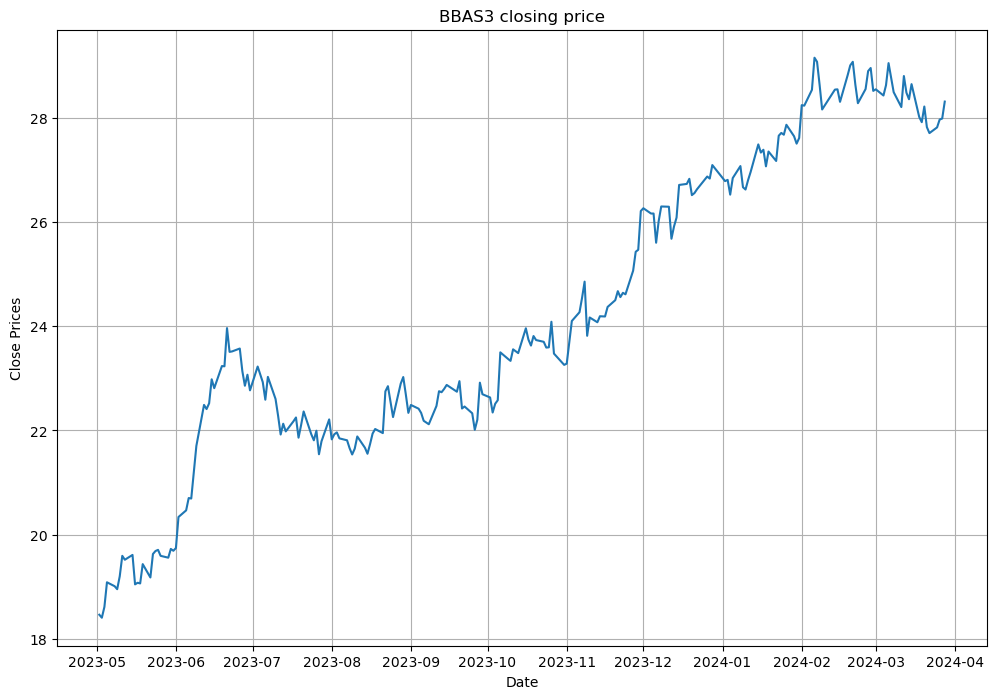

16:00:01 - cmdstanpy - INFO - Chain [1] start processing
16:00:01 - cmdstanpy - INFO - Chain [1] done processing


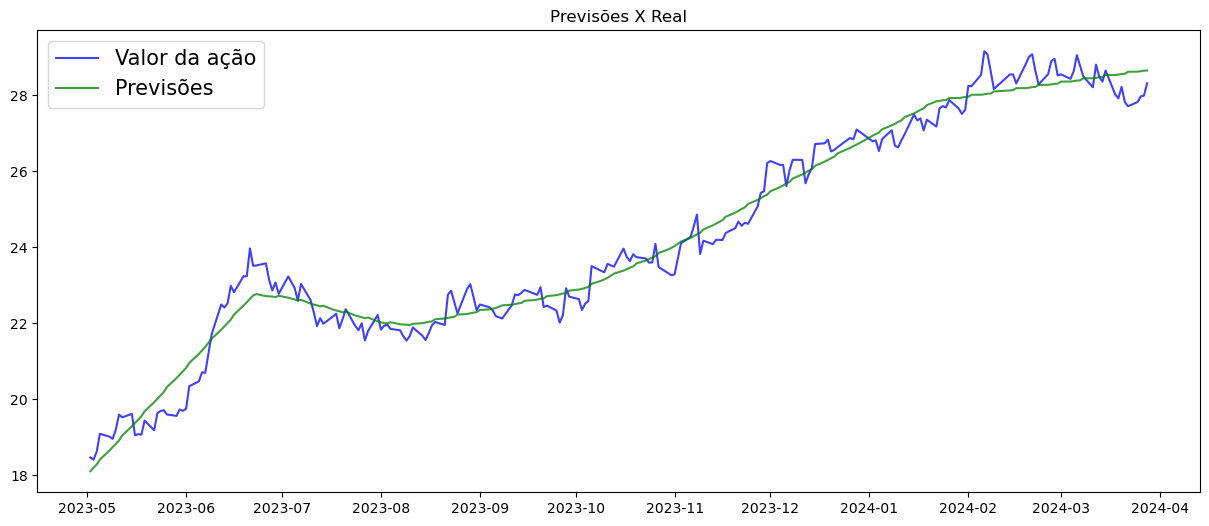

  0%|          | 0/82 [00:00<?, ?it/s]

16:00:02 - cmdstanpy - INFO - Chain [1] start processing
16:00:02 - cmdstanpy - INFO - Chain [1] done processing
16:00:02 - cmdstanpy - INFO - Chain [1] start processing
16:00:03 - cmdstanpy - INFO - Chain [1] done processing
16:00:03 - cmdstanpy - INFO - Chain [1] start processing
16:00:03 - cmdstanpy - INFO - Chain [1] done processing
16:00:03 - cmdstanpy - INFO - Chain [1] start processing
16:00:03 - cmdstanpy - INFO - Chain [1] done processing
16:00:04 - cmdstanpy - INFO - Chain [1] start processing
16:00:04 - cmdstanpy - INFO - Chain [1] done processing
16:00:04 - cmdstanpy - INFO - Chain [1] start processing
16:00:04 - cmdstanpy - INFO - Chain [1] done processing
16:00:05 - cmdstanpy - INFO - Chain [1] start processing
16:00:05 - cmdstanpy - INFO - Chain [1] done processing
16:00:05 - cmdstanpy - INFO - Chain [1] start processing
16:00:05 - cmdstanpy - INFO - Chain [1] done processing
16:00:05 - cmdstanpy - INFO - Chain [1] start processing
16:00:05 - cmdstanpy - INFO - Chain [1]

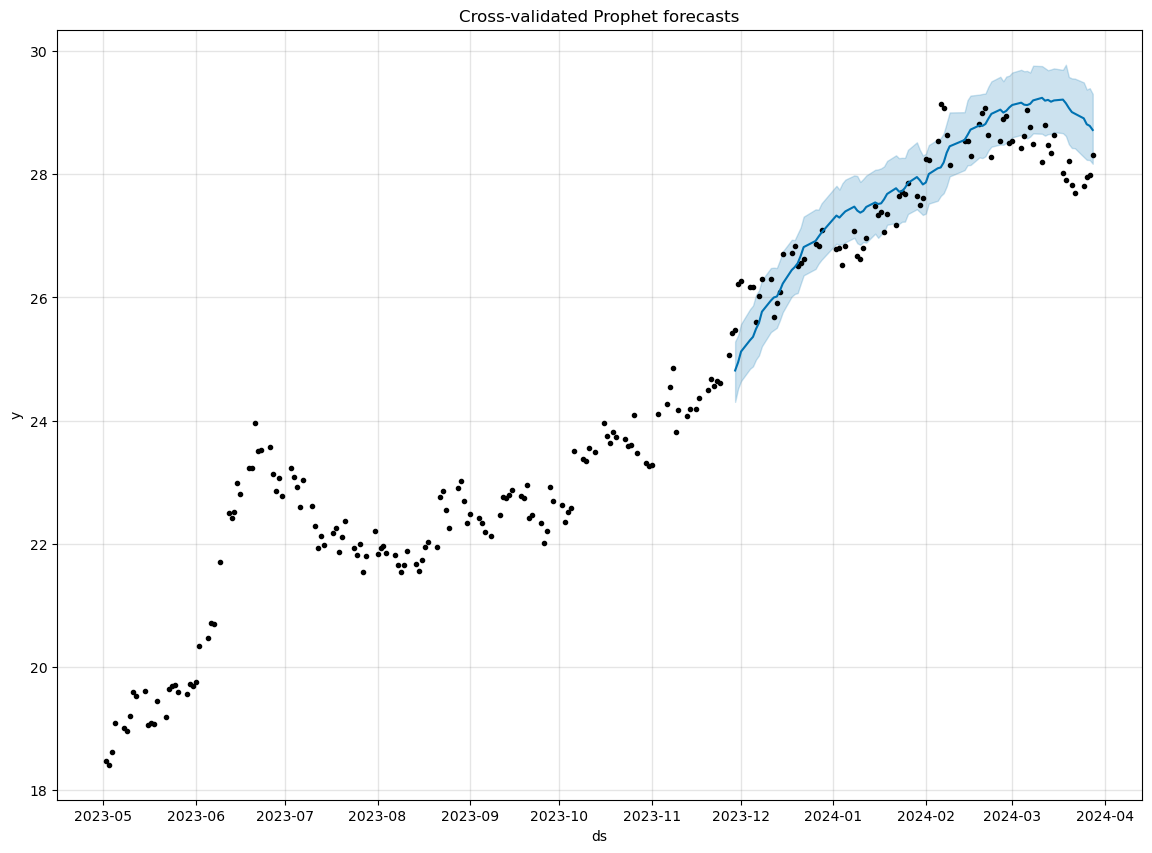


Performance no Conjunto de Teste:
Mean Squared Error (MSE): 0.21215373910254284
Median Absolute Deviation (MAD): 0.3501644442536662
Mean Absolute Error (MAE): 0.38538983631043755
R-squared (R²): 0.9748834639845596


In [5]:
# Importação das bibliotecas necessárias
from prophet import Prophet
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
import datetime
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Importação de funções e constantes específicas
from functions.stock import download_stock_data
from const.interval import Interval

# Definição do símbolo da ação e download dos dados históricos
symbol = 'BBAS3.SA'
stock_data = download_stock_data(symbol, Interval.DAY.value, 365)

# Exibição dos dados baixados
display(stock_data)

# Informações sobre os dados
stock_data.info()

# Preparação dos dados para o modelo Prophet
data = stock_data[['Adj Close']].copy()
data.index = pd.to_datetime(data.index)
#data['ds'] = data.index.strftime('%Y-%m-%d %H:%M:%S') #para os dados/hora
data['ds'] = data.index.strftime('%Y-%m-%d') #para os dados/dia

# Realização de análise técnica (Média Móvel Exponencial de 21 dias) e anexação ao dataset
data.ta.ema(close='Adj Close', length=21, append=True)

# Remoção de valores ausentes
data.dropna(inplace=True)

# Plotagem do preço de fechamento da ação
plt.figure(figsize=(12,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data['Adj Close'])
plt.title('BBAS3 closing price')
plt.show()

# Seleção dos dados relevantes para o modelo e renomeação de colunas
df_train = data[[ 'ds', 'Adj Close','EMA_21']]
df_train = df_train.rename(columns={"Adj Close": "y"})

# Instanciação do modelo Prophet e ajuste aos dados de treinamento
m = Prophet(daily_seasonality=True)
m.fit(df_train)

# Geração de datas futuras para previsão
future = m.make_future_dataframe(periods=20)
future['day'] =  future['ds'].dt.weekday
future = future[future['day'] <=4]

# Realização das previsões
forecast = m.predict(future)

# Geração de datas futuras (sem período de previsão)
future02 = m.make_future_dataframe(periods=0)
future02['day'] =  future02['ds'].dt.weekday
future02 = future02[future02['day'] <=4]
forecast02 = m.predict(future02)

# Plotagem das previsões
plt.plot(data.index, data['Adj Close'], alpha=0.75, c='b')
plt.plot(forecast02['ds'], forecast02['yhat'], alpha=0.75, c='g') 
plt.legend(['Valor da ação', 'Previsões'], fontsize=15)
plt.title("Previsões X Real")
plt.show()

# Extração das previsões para datas futuras
pred_df = forecast[forecast['ds'] > datetime.datetime.now()][['ds','yhat']]
pred_df.reset_index(inplace=True)
pred_df.drop(labels='index', axis=1,inplace=True)
pred_df.rename(columns={'ds': 'date', 'yhat': 'predicted price'}, inplace=True)

# Execução da validação cruzada
df_cv = cross_validation(m, initial='210 days', period='1 days', horizon='1 days')

# Análise de desempenho da validação cruzada
df_p = performance_metrics(df_cv)

# Plotagem dos resultados da validação cruzada
fig = plt.figure(figsize=(14, 10))
m.plot(df_cv, ax=plt.gca())
plt.title("Cross-validated Prophet forecasts")
plt.show()

# Avaliação de desempenho das previsões usando métricas específicas
from functions.validation import performance_evaluation

prediction_cut = forecast.iloc[:len(df_train)]
test_performance = performance_evaluation(df_train['y'], prediction_cut['yhat'])

print("\nPerformance no Conjunto de Teste:")
for metric, value in test_performance.items():
    print(f'{metric}: {value}')

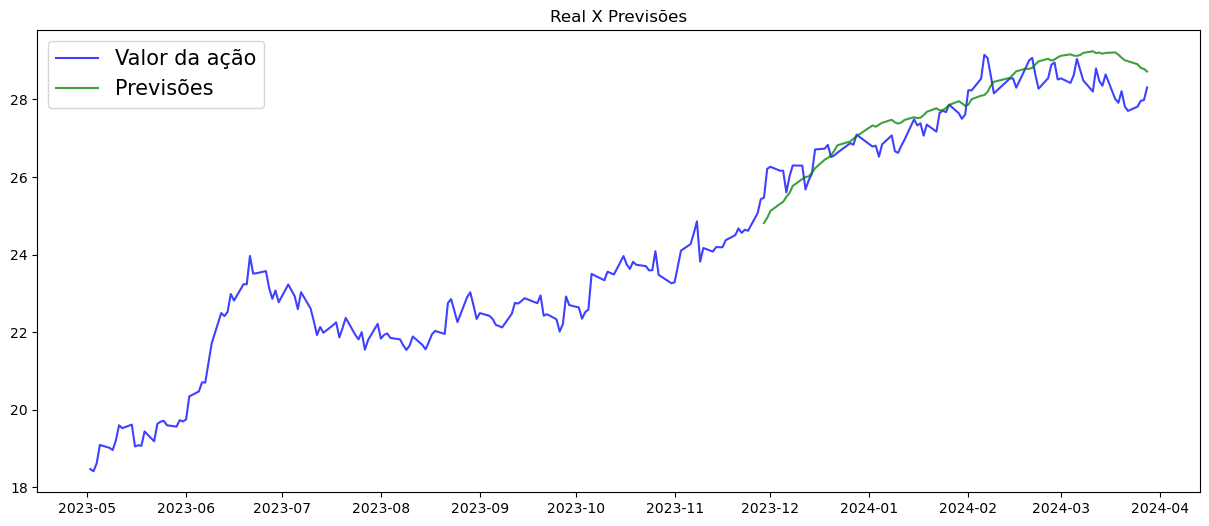

In [6]:
# Plotagem das previsões
plt.plot(data.index, data['Adj Close'], alpha=0.75, c='b')
plt.plot(df_cv['ds'], df_cv['yhat'], alpha=0.75, c='g')
plt.legend(['Valor da ação', 'Previsões'], fontsize=15)
plt.title("Real X Previsões")
plt.show()

In [7]:
# Avaliação de desempenho das previsões usando métricas específicas
from functions.validation import performance_evaluation

test_performance = performance_evaluation(df_cv['y'], df_cv['yhat'])

print("\nPerformance no Conjunto Cross validation:")
for metric, value in test_performance.items():
    print(f'{metric}: {value}')


Performance no Conjunto Cross validation:
Mean Squared Error (MSE): 0.34690323365361947
Median Absolute Deviation (MAD): 0.41613780370013487
Mean Absolute Error (MAE): 0.47520254313012017
R-squared (R²): 0.6433945408299473
